In [ ]:
!pip install osmnx
!pip install mapclassify
!pip install geopy
!pip install alphashape
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.9/708.9 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.colors as mcolors


In [ ]:
from geopandas import overlay

In [ ]:
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import geopandas as gpd
import contextily as ctx
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import mapclassify
import folium
import matplotlib
import geopy.distance
import numpy as np
from shapely.geometry import Point, MultiPoint
from shapely.ops import unary_union
import geemap
import geopandas as gpd
import shapely.wkt
from alphashape import alphashape
from shapely.geometry import shape, Polygon, MultiPolygon, GeometryCollection, MultiPoint, Point
import pickle

Mounted at /content/drive


In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project="ee-sarahheinz0405")

# Straßennetzwerke direkt über Stadtname laden

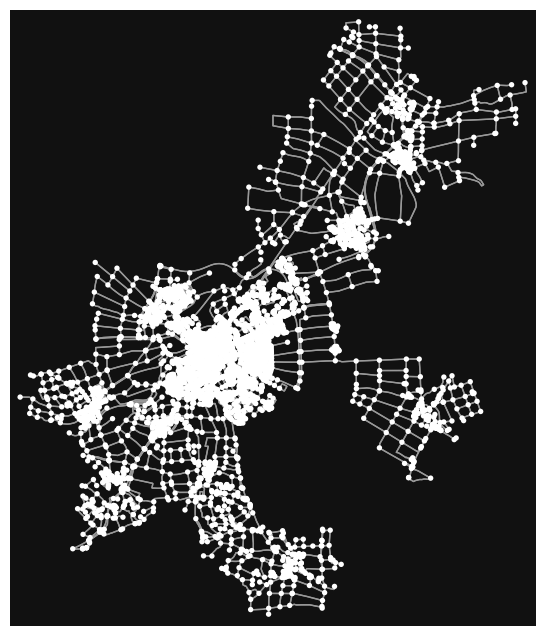

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
G_Noerdlingen = ox.graph_from_place('Noerdlingen, Germany', network_type='walk')
ox.plot_graph(G_Noerdlingen)

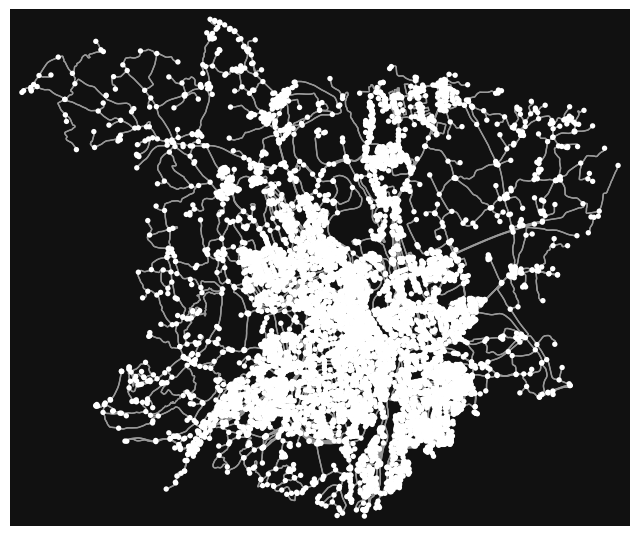

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
G_Kempten = ox.graph_from_place('Kempten, Germany', network_type='walk')
ox.plot_graph(G_Kempten)

In [ ]:
G_Ingolstadt = ox.graph_from_place('Ingolstadt, Germany', network_type='walk')
ox.plot_graph(G_Ingolstadt)

In [ ]:
# Optional: Speichern der Netzwerke im GraphML-Format
#ox.save_graphml(G_Noerdlingen, filepath='noerdlingen_strassennetz.graphml')
#ox.save_graphml(G_Kempten, filepath='kempten_strassennetz.graphml')
#ox.save_graphml(G_Ingolstadt, filepath='ingolstadt_strassennetz.graphml')

In [ ]:
G_Noerdlingen = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml')
G_Kempten = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml')
G_Ingolstadt = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml')

In [ ]:
# Definiere die Pfade zu den GraphML-Dateien
graphml_files = [
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml",
]

# Definiere die Pfade für die GeoPackages
geopackage_files = [
    "Wegenetz_Noerdlingen.gpkg",
    "Wegenetz_Kempten.gpkg",
    "Wegenetz_Ingolstadt.gpkg",
]

# Schleife durch die GraphML-Dateien und speichere sie als GeoPackages
for i, graphml_file in enumerate(graphml_files):
    # Lade den Graphen aus der GraphML-Datei
    G = ox.load_graphml(graphml_file)
    # Speichere den Graphen als GeoPackage
    ox.io.save_graph_geopackage(G, filepath=geopackage_files[i])
    print(f"Graph aus {graphml_file} als {geopackage_files[i]} gespeichert.")

Graph aus /content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml als Wegenetz_Noerdlingen.gpkg gespeichert.
Graph aus /content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml als Wegenetz_Kempten.gpkg gespeichert.
Graph aus /content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml als Wegenetz_Ingolstadt.gpkg gespeichert.


Cold-Spots Polygone laden

In [ ]:
# Cold Spots aus einer Datei laden (Beispiel: GeoJSON)
cold_spot_Ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_Polygon.geojson")
cold_spot_Kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_Polygon.geojson")
cold_spot_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_Polygon.geojson")


In [ ]:
print(cold_spot_Ingolstadt.crs)
print(cold_spot_Kempten.head(10))
print(cold_spot_Noerdlingen.head(10))

EPSG:4326
                                            geometry
0  MULTIPOINT (10.25144 47.71334, 10.25144 47.713...
                                            geometry
0  MULTIPOINT (10.44089 48.80938, 10.44116 48.806...


nearest nodes von osmnx: Zentroid Methode hier nicht sinnvoll, bringt ungenaues Ergebnis bei unsymmetrischen, langgestreckten Cold Spots

deshalb: Linienbasierte Erreichbarkeitsanalyse mit Grenze der Polygone als Ausgangslinie

ausgehend von den gruppierten Cold Spots (dissolved_Noerdlingen,...) für jeden Cold Spot eine linienbasierte Erreichbarkeitsanalyse durchführen: entlang der Grenzen der Cold Spots in regelmäßigen Abständen (50 m) eine Reihe von Ausgangspunkten generieren

 Für jeden dieser Punkte wird der nächstgelegene Knoten im Fußgängernetzwerk (G_Noerdlingen,...) bestimmt. Anschließend wird für jeden dieser Startknoten eine Isochrone (Erreichbarkeitszone) für 5, 10 und 15 Minuten berechnet – bei einer Gehgeschwindigkeit von 1 m/s entspricht das 300, 600 bzw. 900 m. Zum Schluss werden für jeden Cold Spot die Isochronen der einzelnen Startpunkte pro Zeitlimit vereinigt.

überlappende Polygone sollen als ein feature gesehen werden, und alleinstehende ebenso als eines: dafür: nach überlappungen suchen, diese dann zusammenführen und schließlich jedem Cold Spot eine Cluster ID hinzufügen (um überlappende als Gruppe zu sehen), um schließlich die Geometrien zu vereinigen

dafür vorher noch: POINTS (Cold Spots) in Polygone umwandeln => mit buffer Befehl (100m, weil Landsat Pixel auch 100m Auflösung haben)

# Service Areas für Nördlingen, Kempten und Ingolstadt

Cold Spots gruppieren, sodass überlappende als einer gesehen werden

In [ ]:
# Cold Spots aus einer Datei laden (Beispiel: GeoJSON)
cold_spot_Ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_Polygon.geojson")
cold_spot_Kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_Polygon.geojson")
cold_spot_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_Polygon.geojson")


In [ ]:
def cluster_cold_spots(gdf):
    """
    Gruppiert Cold Spots basierend auf Überschneidungen und weist Cluster-IDs zu.

    Args:
        gdf: GeoDataFrame mit Cold Spot-Geometrien.

    Returns:
        GeoDataFrame mit zusätzlicher Spalte 'cluster_id'.
    """

    # Kopie des GeoDataFrames erstellen
    gdf_clustered = gdf.copy().reset_index(drop=True)

    # Geometrien umwandeln
    gdf_clustered = gdf_clustered.to_crs(epsg=32632)

    # Explodiere MultiPolygone in einzelne Polygone und setze den Index neu
    gdf_clustered = gdf_clustered.explode(index_parts=True).reset_index(drop=True)

    # Überprüfen, ob es sich um Punkte handelt und diese in Polygone umwandeln
    if gdf_clustered.geometry.iloc[0].geom_type in ['Point', 'MultiPoint']:
        buffer_distance = 100  # 100m, weil Landsat Pixel auch 100m Auflösung haben
        print(f"Anwenden eines Buffers von {buffer_distance} Metern auf Punktgeometrien.")
        gdf_clustered['geometry'] = gdf_clustered.geometry.buffer(buffer_distance)

    # --- Aufbau des Graphen zur Cluster-Bildung ---
    G = nx.Graph()
    for idx in gdf_clustered.index:
        G.add_node(idx)

    sindex = gdf_clustered.sindex
    for idx, geom in gdf_clustered.geometry.items():
        possible_matches_index = list(sindex.intersection(geom.bounds))
        for other_idx in possible_matches_index:
            if idx < other_idx:
                # Hier wird überprüft, ob sich die Polygone überschneiden
                if geom.intersects(gdf_clustered.loc[other_idx, 'geometry']):
                    G.add_edge(idx, other_idx)

    clusters = list(nx.connected_components(G))
    print("Gefundene Cluster:", clusters)

    # Mapping: Jeder ursprüngliche Index erhält eine Cluster-ID
    cluster_mapping = {}
    for cluster_id, component in enumerate(clusters):
        for idx in component:
            cluster_mapping[idx] = cluster_id

    gdf_clustered['cluster_id'] = gdf_clustered.index.map(cluster_mapping)

    # Polygone innerhalb des gleichen Clusters zusammenführen
    gdf_dissolved = gdf_clustered.dissolve(by='cluster_id', aggfunc='first') # 'first' behält die Attribute des ersten Features bei

    # Geometrie in Polygon oder MultiPolygon umwandeln (falls nötig)
    gdf_dissolved['geometry'] = gdf_dissolved['geometry'].apply(lambda geom: geom if isinstance(geom, (Polygon, MultiPolygon)) else geom.convex_hull)

    return gdf_dissolved

# Wende die Funktion auf die Cold Spot-Dateien an
cold_spot_Ingolstadt = cluster_cold_spots(cold_spot_Ingolstadt)
cold_spot_Kempten = cluster_cold_spots(cold_spot_Kempten)
cold_spot_Noerdlingen = cluster_cold_spots(cold_spot_Noerdlingen)

# Speichere die bearbeiteten Dateien
cold_spot_Ingolstadt.to_file("Ingolstadt_ColdSpots_clustered.geojson", driver="GeoJSON")
cold_spot_Kempten.to_file("Kempten_ColdSpots_clustered.geojson", driver="GeoJSON")
cold_spot_Noerdlingen.to_file("Noerdlingen_ColdSpots_clustered.geojson", driver="GeoJSON")

Gefundene Cluster: [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}]
Gefundene Cluster: [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}]
Gefundene Cluster: [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}]


geclusterte(gruppierte Cold Spots laden)

In [ ]:
cold_spots_Kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_clustered.geojson")
cold_spots_Ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_clustered.geojson")
cold_spots_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_clustered.geojson")

In [ ]:
cold_spots_Kempten = cold_spots_Kempten.to_crs(epsg=4326)
cold_spots_Ingolstadt = cold_spots_Ingolstadt.to_crs(epsg=4326)
cold_spots_Noerdlingen = cold_spots_Noerdlingen.to_crs(epsg=4326)

In [ ]:
print("Ingolstadt:")
print(cold_spots_Ingolstadt)

print("\nKempten:")
print(cold_spots_Kempten)

print("\nNördlingen:")
print(cold_spots_Noerdlingen)

Ingolstadt:
    cluster_id                                           geometry
0            0  POLYGON ((11.27742 48.75987, 11.27732 48.75992...
1            1  POLYGON ((11.29031 48.7643, 11.29018 48.76433,...
2            2  POLYGON ((11.31796 48.73853, 11.31785 48.73858...
3            3  POLYGON ((11.31149 48.74985, 11.31138 48.7499,...
4            4  POLYGON ((11.31253 48.73464, 11.3124 48.73464,...
5            5  POLYGON ((11.31646 48.74665, 11.31642 48.74657...
6            6  POLYGON ((11.31673 48.72771, 11.31661 48.72775...
7            7  POLYGON ((11.31603 48.73652, 11.3159 48.73652,...
8            8  POLYGON ((11.36051 48.7301, 11.36039 48.73013,...
9            9  POLYGON ((11.3698 48.74274, 11.36968 48.74277,...
10          10  POLYGON ((11.37277 48.70771, 11.37264 48.70773...
11          11  POLYGON ((11.37616 48.72895, 11.37606 48.72889...
12          12  POLYGON ((11.38044 48.71092, 11.38031 48.71092...
13          13  POLYGON ((11.41847 48.75213, 11.41837 48.75207..

In [ ]:
cold_spots_Kempten.to_csv("Kempten_ColdSpots_clustered.csv", index=False)
cold_spots_Ingolstadt.to_csv("Ingolstadt_ColdSpots_clustered.csv", index=False)
cold_spots_Noerdlingen.to_csv("Noerdlingen_ColdSpots_clustered.csv", index=False)

umwandeln in shapefile (um ggf in qgis zu verwenden)

In [ ]:
# Definiere den Pfad für die Ausgabedatei (Shapefile)
shapefile_Noerdlingen = "ColdSpots_Noerdlingen.shp"
shapefile_Kempten = "ColdSpots_Kempten.shp"
shapefile_Ingolstadt = "ColdSpots_Ingolstadt.shp"

# Dateien lesen
Kempten_gdf = cold_spots_Kempten
Noerdlingen_gdf = cold_spots_Noerdlingen
Ingolstadt_gdf = cold_spots_Ingolstadt

# Funktion zum Zuweisen und Umwandeln der Geometriespalte
def assign_and_convert_geometry(gdf):
    """Weist die Geometriespalte zu und konvertiert sie in den richtigen Geometrietyp."""
    gdf.geometry = gdf.geometry.apply(lambda geom: geom if isinstance(geom, (Polygon, MultiPolygon)) else geom.convex_hull)
    gdf.geometry = gpd.GeoSeries(gdf.geometry, crs=gdf.crs)
    gdf = gpd.GeoDataFrame(gdf[['cluster_id', 'geometry']], geometry='geometry', crs=gdf.crs) # 'geometry' und 'cold_spot_id' durch die tatsächlichen Spaltennamen ersetzen, falls abweichend
    gdf = gdf.reset_index(drop=True)
    return gdf

# Anwendung der Funktion und Schreiben in Shapefiles
Noerdlingen_gdf = assign_and_convert_geometry(Noerdlingen_gdf)
Noerdlingen_gdf.to_file(shapefile_Noerdlingen, driver="ESRI Shapefile")
Noerdlingen_gdf.to_file("ColdSpots_Noerdlingen.geojson", driver="GeoJSON")

Kempten_gdf = assign_and_convert_geometry(Kempten_gdf)
Kempten_gdf.to_file(shapefile_Kempten, driver="ESRI Shapefile")
Noerdlingen_gdf.to_file("ColdSpots_Kemoten.geojson", driver="GeoJSON")

Ingolstadt_gdf = assign_and_convert_geometry(Ingolstadt_gdf)
Ingolstadt_gdf.to_file(shapefile_Ingolstadt, driver="ESRI Shapefile")
Noerdlingen_gdf.to_file("ColdSpots_Ingolstadt.geojson", driver="GeoJSON")

print(f"GeoJSON-Dateien erfolgreich in Shapefiles konvertiert.")


GeoJSON-Dateien erfolgreich in Shapefiles konvertiert.


Verwendung in QGIS funktioniert nicht! Attributtabelle von Shapefile (auch von geojson) zeigt geometry spalte nicht an, obwohl Datentyp stimmt...

# Visualisieren

Punkte im Abstand von x (hier 5) Metern an Außenlinie der Polygone gelten als Startpunkte => nearest nodes => Erreichbarkeit 5, 10, 15 Minuten

--- Verarbeitung von Noerdlingen ---
--- Noerdlingen abgeschlossen ---


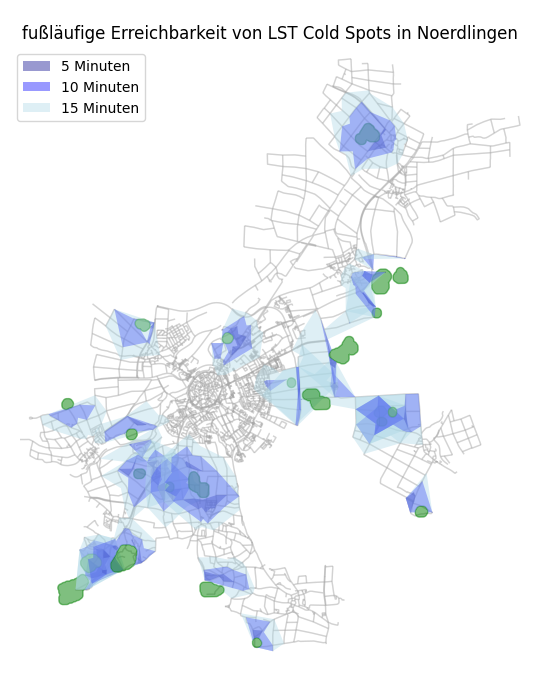

--- Verarbeitung von Kempten ---
--- Kempten abgeschlossen ---


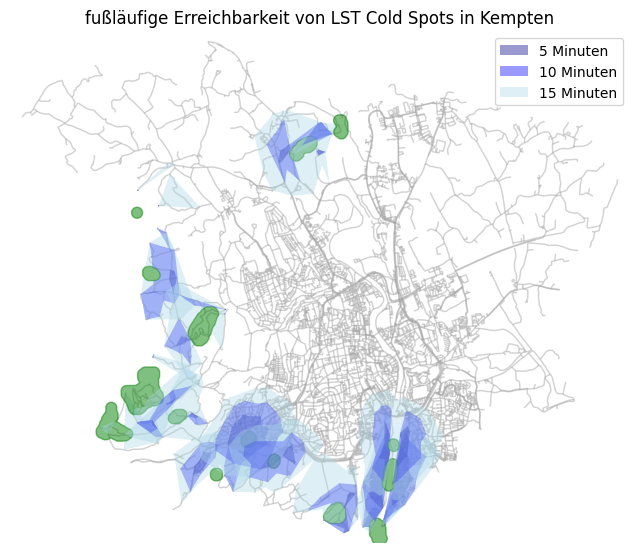

--- Verarbeitung von Ingolstadt ---
--- Ingolstadt abgeschlossen ---


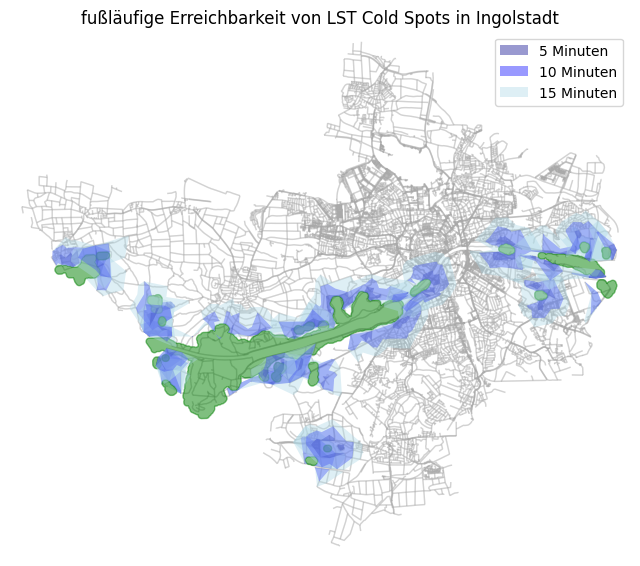

In [ ]:
# Parameter festlegen
walk_speed = 1  # Gehgeschwindigkeit in m/s (entspricht ca. 5 km/h)
time_thresholds = [300, 600, 900]  # 5, 10 und 15 Minuten in Sekunden
colors = {300: 'darkblue', 600: 'blue', 900: 'lightblue'}
point_interval = 5  # Abstand der Punkte entlang der Außenlinie in Metern


def sample_points_on_line(line, interval):
    """Erzeugt Punkte entlang einer LineString-Geometrie in regelmäßigen Abständen."""
    distances = np.arange(0, line.length, interval)
    points = [line.interpolate(distance) for distance in distances]
    return points


# Schleife über die Städte und Cold Spots
for stadt, cold_spot_data, graph in [("Noerdlingen", cold_spot_Noerdlingen, G_Noerdlingen),
                                    ("Kempten", cold_spot_Kempten, G_Kempten),
                                    ("Ingolstadt", cold_spot_Ingolstadt, G_Ingolstadt)]:
    print(f"--- Verarbeitung von {stadt} ---")

    # Projiziere den Graphen in UTM Zone 32N
    graph_proj = ox.project_graph(graph, to_crs='epsg:32632')

    # Füge die 'travel_time' Attribut zu den Kanten hinzu
    for u, v, key, data in graph_proj.edges(keys=True, data=True):
        data['travel_time'] = data.get('length', 0) / walk_speed

    # Projiziere den Cold Spot GeoDataFrame in die gleiche Projektion wie der Graph
    cold_spot_data_proj = cold_spot_data.to_crs(graph_proj.graph['crs'])

    # --- Hier wird der results-Dictionary initialisiert ---
    results = []

    # Erstelle eine Figure und ein Axes-Objekt vor der Schleife
    fig, ax = ox.plot_graph(graph_proj, show=False, close=False, node_size=0,
                           edge_color='darkgray', edge_alpha=0.3, bgcolor='white')

    # Legende-Handles und Labels - Initialisieren Sie sie hier, aber fügen Sie sie später hinzu
    legend_handles = []
    legend_labels = []

    # Schleife über alle Cold Spots der Stadt
    for idx, row in cold_spot_data_proj.iterrows():
        cold_spot_polygon = row.geometry

        # Zeichne den Cold Spot als Polygon
        x, y = cold_spot_polygon.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='green', ec='green', label="Cold Spot")  # Zeichne Cold Spot hier

        # Erzeuge Punkte entlang der Außenlinie des Cold Spots
        boundary_line = cold_spot_polygon.boundary
        boundary_points = sample_points_on_line(boundary_line, point_interval)

        # Isochronen für jedes Zeitlimit speichern
        isochrones_per_threshold = {thresh: [] for thresh in time_thresholds}

        # Berechne die Erreichbarkeiten von den Punkten entlang der Außenlinie
        for point in boundary_points:
            # Finde den nächstgelegenen Knoten zum Punkt
            nearest_node = ox.distance.nearest_nodes(graph_proj, X=point.x, Y=point.y)

            # Berechne die Isochronen für die Zeitlimits, aber nur außerhalb des Cold Spots
            for time_limit in time_thresholds:
                subgraph = nx.ego_graph(graph_proj, nearest_node, radius=time_limit, distance='travel_time')
                node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)
                               if not cold_spot_polygon.contains(Point(data['x'], data['y']))]  # Nur Punkte außerhalb

                # Wenn weniger als 3 Punkte erreichbar sind, verwende den nächstgelegenen Knotenpunkt
                if len(node_points) < 3:
                    polygon = Point(graph_proj.nodes[nearest_node]['x'], graph_proj.nodes[nearest_node]['y']).buffer(10)
                    polygon = polygon.difference(cold_spot_polygon)  # Überlappenden Bereich entfernen
                else:
                    polygon = unary_union(node_points).convex_hull
                    polygon = polygon.difference(cold_spot_polygon)  # Überlappenden Bereich entfernen

                isochrones_per_threshold[time_limit].append(polygon)  # Isochrone speichern

       # --- Hier wird das Ergebnis an den results-Dictionary angehängt ---
        results.append({
            'cold_spot_id': idx,
            'geometry': cold_spot_polygon,  # Originalgeometrie des Cold Spots
            'service_5min': unary_union(isochrones_per_threshold[300]) if isochrones_per_threshold[300] else None,
            'service_10min': unary_union(isochrones_per_threshold[600]) if isochrones_per_threshold[600] else None,
            'service_15min': unary_union(isochrones_per_threshold[900]) if isochrones_per_threshold[900] else None
        })

        # Isochronen für jedes Zeitlimit zusammenführen und zeichnen
        for time_limit in time_thresholds:
            # Alle Isochronen für dieses Zeitlimit zu einer einzigen Geometrie zusammenführen
            merged_isochrone = unary_union(isochrones_per_threshold[time_limit])

            # Zeichne die zusammengeführte Isochrone, berücksichtige MultiPolygon
            if merged_isochrone.geom_type == 'Polygon':
                x, y = merged_isochrone.exterior.xy
                handle = ax.fill(x, y, alpha=0.4, fc=colors[time_limit], ec='none')  # Now using ax from outer scope
            elif merged_isochrone.geom_type == 'MultiPolygon':
                for polygon in merged_isochrone.geoms:  # Iteriere durch die Polygone im MultiPolygon
                    x, y = polygon.exterior.xy
                    handle = ax.fill(x, y, alpha=0.4, fc=colors[time_limit], ec='none')  # Now using ax from outer scope
            else:
                # Handle other geometry types if necessary
                pass

            # Füge Handle und Label zur Legende hinzu (nur einmal pro Zeitlimit)
            label = f'{time_limit / 60:.0f} Minuten'
            if label not in legend_labels:
                legend_handles.append(handle[0])  # Assuming handle is a list
                legend_labels.append(label)


    # --- Speichern des results-Dictionarys als Pickle-Datei ---
    with open(f'service_area_results_{stadt}.pickle', 'wb') as f:
        pickle.dump(results, f)

    # --- Erstellen und Speichern des GeoDataFrames ---
    service_area_gdf = gpd.GeoDataFrame(results, crs=cold_spot_data_proj.crs)
    service_area_gdf.to_file(f"service_area_gdf_{stadt}.geojson", driver="GeoJSON")

    print(f"--- {stadt} abgeschlossen ---")

    # Setze den Titel und die Legende für den Plot - außerhalb der Schleife
    ax.set_title(f"fußläufige Erreichbarkeit von LST Cold Spots in {stadt}")
    ax.legend(handles=legend_handles, labels=legend_labels)
    plt.show()  # Zeige den Plot außerhalb der Schleife

In [ ]:
#pickle-Dateien (mit results) laden
with open("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Ingolstadt.pickle", 'rb') as f:
    results_Ingolstadt = pickle.load(f)
    print(results_Ingolstadt)

with open("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Kempten.pickle", 'rb') as f:
    results_Kempten = pickle.load(f)
    print(results_Kempten)

with open("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Noerdlingen.pickle", 'rb') as f:
    results_Noerdlingen = pickle.load (f)
    print(results_Noerdlingen)

[{'cold_spot_id': 0, 'geometry': <POLYGON ((667370.175 5403263.678, 667362.293 5403269.524, 667355.021 540327...>, 'service_5min': <MULTIPOLYGON (((666906.834 5403822.138, 666932.424 5403779.626, 667027.57 5...>, 'service_10min': <POLYGON ((666916.811 5404047.346, 666963.066 5404064.178, 667013.375 540412...>, 'service_15min': <POLYGON ((667408.4 5403595.662, 667401.448 5403596.003, 667391.646 5403595....>}, {'cold_spot_id': 1, 'geometry': <POLYGON ((668301.879 5403785.293, 668292.36 5403787.677, 668283.12 5403790....>, 'service_5min': <MULTIPOLYGON (((668237.34 5403968.882, 668232.295 5403960.465, 668228.099 5...>, 'service_10min': <POLYGON ((668195.833 5403485.082, 667672.99 5403854.021, 667815.199 5404118...>, 'service_15min': <POLYGON ((667464.032 5403822.966, 667528.922 5404101.462, 668218.228 540421...>}, {'cold_spot_id': 2, 'geometry': <POLYGON ((670421.19 5400981.927, 670412.773 5400986.972, 670404.89 5400992....>, 'service_5min': <MULTIPOLYGON (((670221.775 5400845.539, 670307

In [ ]:
# Convert results to GeoDataFrame and set CRS
results_Ingolstadt = gpd.GeoDataFrame(results_Ingolstadt, crs="epsg:4326")  # Assuming your data is in EPSG:4326
results_Kempten = gpd.GeoDataFrame(results_Kempten, crs="epsg:4326")
results_Noerdlingen = gpd.GeoDataFrame(results_Noerdlingen, crs="epsg:4326")

# Now you can print the CRS
print(results_Ingolstadt.crs)

epsg:4326


graph ml Datei aufbereiten für QGIS


In [ ]:
# Graph aus der GraphML-Datei laden
G_Noerdlingen = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml')
G_Kempten = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml')
G_Ingolstadt = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml')


# save graph as a geopackage
ox.io.save_graph_geopackage(G_Noerdlingen, filepath="Wegenetz_Noerdlingen.gpkg")
ox.io.save_graph_geopackage(G_Kempten, filepath="Wegenetz_Kempten.gpkg")
ox.io.save_graph_geopackage(G_Ingolstadt, filepath="Wegenetz_Ingolstadt.gpkg")

# verknüpfen mit Bevölkerungsdaten

wieviel Prozent der jeweiligen Bevölkerungsgruppen erreichen cold spots innerhalb von 5, 10 und 15 Minuten?

welche Bevölkerungsgruppen leben tendenziell näher an Cold Spots, gibt es da überhaupt Muster?




Bevölkerungsdaten bearbeiten: aus Punkten Polygone machen um zusammenhängende zu erkennen > klassifizieren

In [ ]:
alle_staedte_cluster = pd.read_csv('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/alle_staedte_cluster.csv')


In [ ]:
print(alle_staedte_cluster.head())

                   GITTER_ID_100m  x_mp_100m  y_mp_100m  \
0  CRS3035RES100mN2854400E4359000    4359050    2854450   
1  CRS3035RES100mN2854500E4358400    4358450    2854550   
2  CRS3035RES100mN2854500E4358700    4358750    2854550   
3  CRS3035RES100mN2854500E4358800    4358850    2854550   
4  CRS3035RES100mN2854500E4358900    4358950    2854550   

                  geometry  AnteilUeber65  AnteilAuslaender  \
0  POINT (4359050 2854450)            NaN               NaN   
1  POINT (4358450 2854550)            NaN               NaN   
2  POINT (4358750 2854550)            NaN               NaN   
3  POINT (4358850 2854550)          13.64               NaN   
4  POINT (4358950 2854550)            NaN               NaN   

   durchschnFlaechejeBew  Durchschnittsalter  Einwohner  durchschnMieteQM  \
0                  65.00               37.13          3               NaN   
1                    NaN               53.48          3               NaN   
2                  39.04           

Punkte in Gitterzellen umwandeln und so visualisieren

In [ ]:
Noerdlingen_df = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/NOERDLINGEN_neu_merged.csv")
Kempten_df = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/KEMPTEN_neu_merged_2.csv")
Ingolstadt_df = pd.read_csv("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/INGOLSTADT_neu_merged_2.csv")

In [ ]:
alle_staedte_cluster = gpd.read_file('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/alle_staedte_cluster.csv')
# Definiere das Koordinatensystem, falls es nicht in der CSV-Datei enthalten ist:
alle_staedte_cluster.crs = 'epsg:3035'

# Convert 'x_mp_100m' and 'y_mp_100m' columns to numeric
alle_staedte_cluster['x_mp_100m'] = pd.to_numeric(alle_staedte_cluster['x_mp_100m'])
alle_staedte_cluster['y_mp_100m'] = pd.to_numeric(alle_staedte_cluster['y_mp_100m'])

def create_grid_cell(row):
    """Erstellt ein Polygon (Rechteck) basierend auf den Koordinaten des Mittelpunkts."""
    x = row['x_mp_100m']
    y = row['y_mp_100m']
    # Erstelle die Eckpunkte des Rechtecks:
    # Annahme: x und y sind in einem projizierten Koordinatensystem, wo die Einheiten Meter sind
    p1 = (x - 50, y + 50)  # Links oben
    p2 = (x + 50, y + 50)  # Rechts oben
    p3 = (x + 50, y - 50)  # Rechts unten
    p4 = (x - 50, y - 50)  # Links unten
    # Erstelle das Polygon:
    polygon = Polygon([p1, p2, p3, p4])
    return polygon

#Create geometry column. This will convert the DataFrame to a GeoDataFrame.
alle_staedte_cluster['geometry'] = alle_staedte_cluster.apply(create_grid_cell, axis=1)
#Setting the crs to make sure it's a GeoDataFrame. This was previously set after reading the file.
alle_staedte_cluster = gpd.GeoDataFrame(alle_staedte_cluster, geometry='geometry', crs='epsg:3035')

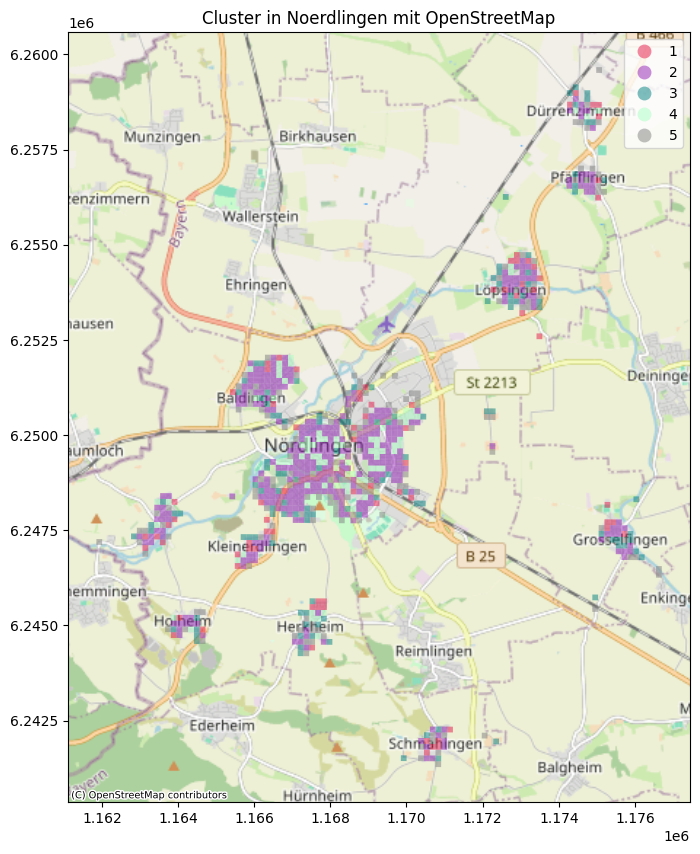

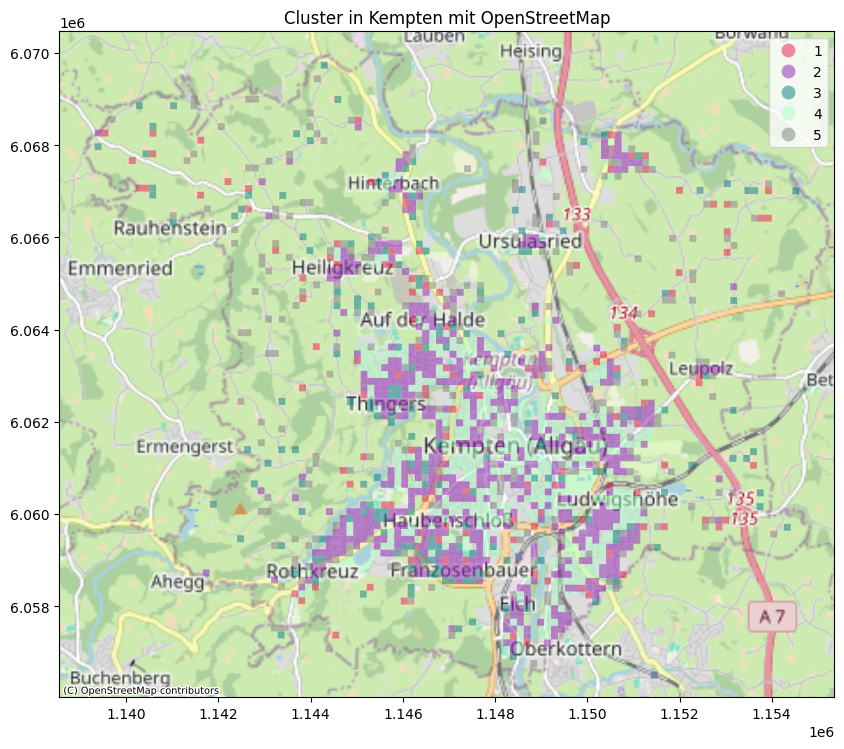

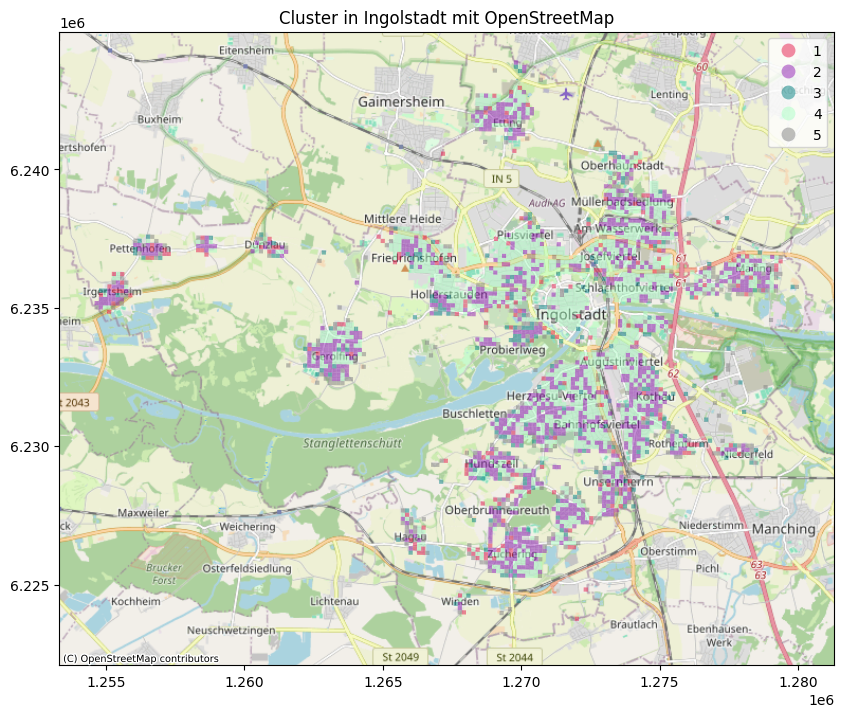

In [ ]:
# Annahme: Noerdlingen_df, Kempten_df, Ingolstadt_df und alle_staedte_cluster sind bereits geladen

# Importiere die benötigten Bibliotheken
import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as gpd

# Definiere das CRS für die Basemap (z.B. Web Mercator)
basemap_crs = "EPSG:3857"

# Erstelle ein Dictionary, das die Gitter-IDs den Städten zuordnet
stadt_gitter_ids = {}
for stadt_df, stadt_name in [(Noerdlingen_df, "Noerdlingen"), (Kempten_df, "Kempten"), (Ingolstadt_df, "Ingolstadt")]:
    stadt_gitter_ids[stadt_name] = stadt_df["GITTER_ID_100m"].unique().tolist()

# Definiere die Basemap-Provider
basemap_providers = {
    "OpenStreetMap": ctx.providers.OpenStreetMap.Mapnik,
}

# Definiere eine Liste mit eindeutigen Farben
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                   '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
                   '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
                   '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']

# Schleife über die Städte und Basemap-Provider
for stadt_name, gitter_ids in stadt_gitter_ids.items():
    for provider_name, provider_source in basemap_providers.items():
        # Erstelle eine Figure und ein Axes-Objekt
        fig, ax = plt.subplots(figsize=(10, 10))

        # Extrahiere die Cluster für die aktuelle Stadt anhand der Gitter-IDs
        stadt_cluster = alle_staedte_cluster[alle_staedte_cluster["GITTER_ID_100m"].isin(gitter_ids)]

        # Konvertiere stadt_cluster in ein GeoDataFrame
        stadt_cluster = gpd.GeoDataFrame(stadt_cluster, geometry='geometry', crs=alle_staedte_cluster.crs)

        # Projiziere die Cluster in das CRS der Basemap
        stadt_cluster = stadt_cluster.to_crs(basemap_crs)

        # Plotte die Cluster auf der Karte mit den eindeutigen Farben
        stadt_cluster.plot(ax=ax, column="cluster", legend=True, alpha=0.5,
                          edgecolor="black", linewidth=0, cmap=mcolors.ListedColormap(distinct_colors))

        # Füge Basemap hinzu (verwende den Bounding Box der Stadt)
        bbox = stadt_cluster.total_bounds
        ctx.add_basemap(ax, crs=basemap_crs, source=provider_source,
                         attribution_size=7, zoom=12)

        # Setze den Titel der Karte
        ax.set_title(f"Cluster in {stadt_name} mit {provider_name}")

        # Zeige die Karte
        plt.show()

In [ ]:
print(alle_staedte_cluster.crs)

epsg:3035


In [ ]:
alle_staedte_cluster.to_csv("alle_staedte_cluster_Gitterzellen.csv", index=False)

In [ ]:
alle_staedte_cluster_Gitterzellen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/alle_staedte_cluster_Gitterzellen.csv")
print(alle_staedte_cluster_Gitterzellen.head())

                   GITTER_ID_100m x_mp_100m y_mp_100m  \
0  CRS3035RES100mN2854400E4359000   4359050   2854450   
1  CRS3035RES100mN2854500E4358400   4358450   2854550   
2  CRS3035RES100mN2854500E4358700   4358750   2854550   
3  CRS3035RES100mN2854500E4358800   4358850   2854550   
4  CRS3035RES100mN2854500E4358900   4358950   2854550   

                                            geometry AnteilUeber65  \
0  POLYGON ((4359000 2854500, 4359100 2854500, 43...                 
1  POLYGON ((4358400 2854600, 4358500 2854600, 43...                 
2  POLYGON ((4358700 2854600, 4358800 2854600, 43...                 
3  POLYGON ((4358800 2854600, 4358900 2854600, 43...         13.64   
4  POLYGON ((4358900 2854600, 4359000 2854600, 43...                 

  AnteilAuslaender durchschnFlaechejeBew Durchschnittsalter Einwohner  \
0                                   65.0              37.13         3   
1                                                     53.48         3   
2                

In [ ]:
# Geodataframe aus den pickle-Dateien

# Definiere die Pfade zu den Pickle-Dateien
pickle_files = [
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Ingolstadt.pickle",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Kempten.pickle",
    "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_results_Noerdlingen.pickle",
]

# Definiere eine Liste, um die GeoDataFrames zu speichern
gdfs = []

# Definiere die Stadtnamen, die den Pickle-Dateien entsprechen
stadt_namen = ["Ingolstadt", "Kempten", "Noerdlingen"]

# Schleife durch die Pickle-Dateien und erstelle GeoDataFrames
for i, file in enumerate(pickle_files):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        # Erstelle einen GeoDataFrame aus den Ergebnissen und setze das CRS
        gdf = gpd.GeoDataFrame(results, crs="epsg:4326")  # Ursprüngliches CRS
        # Projiziere den GeoDataFrame in EPSG 32632
        gdf = gdf.to_crs("epsg:4326")
        # Füge die Spalte "Stadt" hinzu und fülle sie mit dem Stadtnamen
        gdf["Stadt"] = stadt_namen[i]
        gdfs.append(gdf)

# Concatenate GeoDataFrames, ensuring geometry column is preserved
gdfs_merged = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs) # Use the CRS of the first GeoDataFrame

# Set geometry column if it is missing after concatenation
if 'geometry' not in gdfs_merged.columns:
    # Assuming geometry column is named "geometry" in all DataFrames of gdfs
    gdfs_merged = gdfs_merged.set_geometry('geometry')

# Gib den zusammengeführten GeoDataFrame aus
print(gdfs_merged)

    cold_spot_id                                           geometry  \
0              0  POLYGON ((667370.17491 5403263.67837, 667362.2...   
1              1  POLYGON ((668301.879 5403785.29269, 668292.359...   
2              2  POLYGON ((670421.19008 5400981.9267, 670412.77...   
3              3  POLYGON ((669907.51175 5402225.54, 669899.0944...   
4              4  POLYGON ((670035.18281 5400537.39469, 670025.3...   
5              5  POLYGON ((670283.36044 5401881.48639, 670280.9...   
6              6  POLYGON ((670367.44508 5399776.56142, 670358.5...   
7              7  POLYGON ((670286.38505 5400754.89632, 670276.5...   
8              8  POLYGON ((673578.56966 5400141.39703, 673569.3...   
9              9  POLYGON ((674218.00773 5401567.75728, 674208.4...   
10            10  POLYGON ((674557.2035 5397680.56204, 674547.68...   
11            11  POLYGON ((674733.18794 5400049.25551, 674725.9...   
12            12  POLYGON ((675110.5371 5398055.25743, 675100.73...   
13    

In [ ]:
gdfs_merged.to_file("service_area_gdf_merged.geojson", driver="GeoJSON")
gdfs_merged.to_csv("service_area_gdf_merged.csv", index=False)

In [ ]:
print(gdfs_merged.crs)

epsg:4326


In [ ]:
service_areas_merged = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_gdf_all_cities_merged.geojson")

beide kombinieren!

In [ ]:
# 1. Daten vorbereiten
alle_staedte_cluster = alle_staedte_cluster.copy()

# Convert alle_staedte_cluster to a GeoDataFrame explicitly
alle_staedte_cluster = gpd.GeoDataFrame(alle_staedte_cluster, geometry='geometry', crs="32632")

# Konvertieren Sie die Spalte "Einwohner" in einen numerischen Datentyp
alle_staedte_cluster["Einwohner"] = pd.to_numeric(alle_staedte_cluster["Einwohner"])

# Service Areas
cold_spots_merged = service_areas_merged.copy()
cold_spots_merged = gpd.GeoDataFrame(cold_spots_merged, geometry='geometry', crs="4326")
cold_spots_merged = cold_spots_merged.to_crs("32632")


In [ ]:
# 2. Räumliche Verknüpfung
joined_data_intersects = overlay(alle_staedte_cluster, cold_spots_merged, how='intersection') # how kann 'intersection', 'union', 'identity', 'symmetric_difference' sein
print(f"joined_data_intersects shape: {joined_data_intersects.shape}")  # Überprüfen Sie die Form des GeoDataFrames

joined_data_within = gpd.sjoin(alle_staedte_cluster, cold_spots_merged, how='inner', predicate='within')
print(f"joined_data_within shape: {joined_data_within.shape}")  # Überprüfen Sie die Form des GeoDataFrames

joined_data = pd.concat([joined_data_intersects, joined_data_within], ignore_index=True)

joined_data_intersects shape: (0, 17)
joined_data_within shape: (0, 18)


===> Daten sind zwar im gleichen CRS, aber es wird keine Form angezeigt und der Plot zeigt, dass sie auseinander liegen

In [ ]:
joined_data = joined_data.drop_duplicates(subset=['GITTER_ID_100m']) # GITTER_ID_100m als eindeutige ID annehmen


In [ ]:
# 3. Bevölkerung in Erreichbarkeitszonen aggregieren
population_in_zones = joined_data.groupby("cold_spot_id")["Einwohner"].sum()
total_population = alle_staedte_cluster["Einwohner"].sum()
percentage_population = (population_in_zones / total_population) * 100

print(percentage_population)

Series([], Name: Einwohner, dtype: float64)


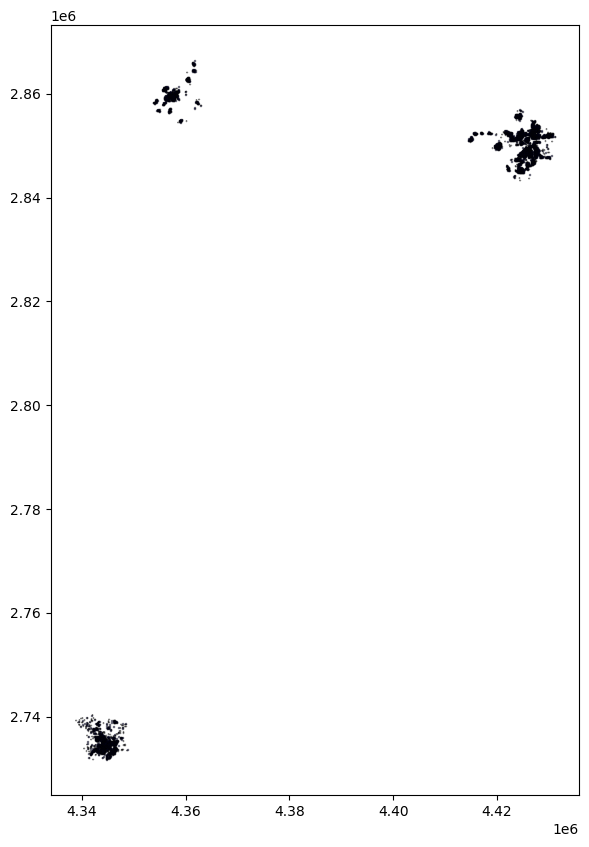

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
alle_staedte_cluster.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black')
cold_spots_merged.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')
plt.show()

In [ ]:
print(alle_staedte_cluster.total_bounds)
print(cold_spots_merged.total_bounds)

[4338600. 2731600. 4431200. 2866500.]
[inf inf inf inf]


Fehler: CRS der Daten stimmt nicht überein. Daten auf gleiches CRS setzen probiert, liefert aber auch keine Ergebnisse ...

Versuch: mit von QGIS erstellten Dateien

In [ ]:
# Erreichbarkeitszonen laden

Noerdlingen_5min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_5min_erreichb.shp")
Noerdlingen_10min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_10min_erreichb.shp")
Noerdlingen_15min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_15min_erreichb.shp")
Noerdlingen_20min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_20min_erreichb.shp")

Kempten_5min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/Kempten_5min_erreichb.shp")
Kempten_10min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_10min_erreichb.shp")
Kempten_15min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_15min_erreichb.shp")
Kempten_20min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_20min_erreichb.shp")

Ingolstadt_5min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_5min_erreichb.shp")
Ingolstadt_10min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_10min_erreichb.shp")
Ingolstadt_15min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_15min_erreichb.shp")
Ingolstadt_20min = gpd.read_file("/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_20min_erreichb.shp")

In [ ]:
print(Noerdlingen_5min.head())

   id  cluster_id      area  perimeter  \
0   0           0  0.000003   0.009066   

                                            geometry  
0  MULTIPOLYGON (((10.44928 48.80912, 10.44895 48...  


In [ ]:
# Definiere eine Liste mit den Dateinamen der Shapefiles
shapefiles = [
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_20min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/Kempten_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_20min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_5min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_10min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_15min_erreichb.shp",
    "/content/drive/MyDrive/Daten BA /QGIS Daten/Ingolstadt/ingolstadt_20min_erreichb.shp",
]

# Schleife durch die Shapefiles
for shapefile in shapefiles:
    # Shapefile laden
    gdf = gpd.read_file(shapefile)

    # CRS setzen, falls es fehlt oder falsch ist
    if gdf.crs is None:
        gdf.crs = 'epsg:4326'  # Ersetze dies durch das tatsächliche CRS des Shapefiles, falls bekannt
    #Falls CRS nicht EPSG:4326 ist, wird es in EPSG:4326 umgewandelt bevor es in EPSG:32632 umgewandelt wird
    elif gdf.crs != 'epsg:4326':
        gdf = gdf.to_crs('epsg:4326')

    # Geometrie in UTM Zone 32N umwandeln
    gdf = gdf.to_crs(epsg=32632)  # UTM Zone 32N

    # Fläche berechnen und ausgeben
    flaeche = gdf.geometry.area.sum()
    print(f"Fläche von {shapefile}: {flaeche:.2f} Quadratmeter")

Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_5min_erreichb.shp: 1686624.06 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_10min_erreichb.shp: 4618583.84 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_15min_erreichb.shp: 8732706.17 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Nördlingen/noerdlingen_20min_erreichb.shp: 14138633.86 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/Kempten_5min_erreichb.shp: 2691255.62 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_10min_erreichb.shp: 5981113.52 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_15min_erreichb.shp: 9947889.46 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Daten/Kempten/kempten_20min_erreichb.shp: 13747534.79 Quadratmeter
Fläche von /content/drive/MyDrive/Daten BA /QGIS Dat

Berechnungen Erreichbarkeit:
1. wieviel % des Staddtgebiets sind innerhalb von x Minuten erreichbar und wieviel % der Bevölkerung (Spalte Einwohner) haben Zugang innerhalb von x Minuten

In [ ]:
# Geodataframe aus shapefiles mit Erreichbarkeiten erstellen


2. Graphen erstellen mit x-Achse (Zeit), Anteil der Bevölkerung der Cold Spot in x-Minuten erreicht (y-Achse), alle 3 Städte als Linie in ein Diagramm

3. visuelle Darstellung: Karte mit Bevölkerungscluster, Cold Spots und Erreichbarkeitszonen